# Connecting ivis with a SQLite Database

In this notebook we will demonstrate how ivis can train and predict on data stored in a SQLite database. Although SQLite is used here, the concepts explored can be applied to any database.

This is just one of the ways of using ivis with large out-of-memory datasets - another option would be to use HDF5 files. If the data already exists in a SQL database, though, it may make sense to interact with the database directly and avoid having to create large files on disk. 

## Imports

In [1]:
import sqlite3

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from ivis import Ivis
from ivis.data.sequence import IndexableDataset

## Creating the SQLite database

In this example we will store the flattened MNIST training set in SQLite. To do this we need to connect to SQLite, create the table and do a batch insert.

The column names will be feature_0, feature_1....feature_783. The training set consists of 60,000 images.

In [2]:
# Load the mnist training set and flatten it
(X_train, Y_train), _ = tf.keras.datasets.mnist.load_data()
X_train = np.reshape(X_train, (len(X_train), -1))

# We could preprocess the data before storing it, but it takes less space to store uint8 than float32
# Instead we will apply preprocessing to each batch as it is pulled from the database
###X_train = np.asarray(X_train, dtype=np.float32) / 255.


def db_connect_fn():
    """Returns a function that returns a SQLite connection.
       When first called it will create a new connection and reuse it for future calls."""
    conn = None
    def _resuable_conn():
        nonlocal conn
        if conn is None:
            conn = sqlite3.connect("mnist.sqlite")
        return conn
    return _resuable_conn


def init_database(connect_fn):
    """This will create an "mnist" table in SQLite and populate it with the values from the MNIST training set."""
    conn = connect_fn()
    cur = conn.cursor()

    columns = [f'feature_{i}' for i in range(X_train.shape[-1])]
    with conn:
        cur.execute(f"CREATE TABLE mnist({','.join(columns)})")
        cur.executemany(f"INSERT INTO mnist VALUES ({','.join(['?'] * len(columns) )})", X_train.tolist())

    conn.close()
    return


init_database(db_connect_fn())

## Validate SQLite dataset

Let's ensure the data stored in SQLite matches the original MNIST dataset by retrieving a row and visualizing it next to the original.

To retrieve rows we will take advantage of SQLite's ROWID - for this example we'll use it as an index. You may use whatever primary key you have if you are using a different SQL database.

SQLite's ROWID starts from 1 and increments with each insert - we have to account for this when retrieving rows since Python uses 0-based indexing.

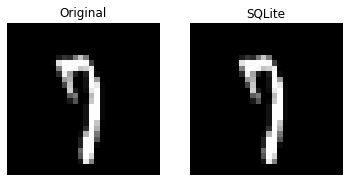

In [3]:
def get_rows(connect_fn, idxes):
    """Returns the data at the requested indices from SQLite as a uint8 numpy array"""
    conn = connect_fn()
    cur = conn.cursor()
    
    # Retrieve rows by ROWID
    rows = cur.execute(f"SELECT rowid, * FROM mnist WHERE rowid IN ({','.join(['?'] * len(idxes))})", idxes).fetchall()

    # In case there are repeated indices in idxes we will map each requested index to its data
    idx_data_dict = {int(row[0]): row[1:] for row in rows}
    rows = np.array([idx_data_dict[i] for i in idxes], dtype=np.uint8)

    conn.close()
    return rows


def draw_imgs(idx):
    """Visualize original image (left) next to database image (right) at requested index"""
    
    # Retrieve image from database - adjust index for 1-based indexed ROWID 
    rows = get_rows(db_connect_fn(), [idx + 1])
    
    # Visualize side-by-side
    _, ax = plt.subplots(ncols=2)
    ax[0].imshow(np.reshape(X_train[idx], (28, 28)), cmap='gray')
    ax[1].imshow(np.reshape(rows[0], (28, 28)), cmap='gray')
    
    ax[0].axis('off')
    ax[1].axis('off')
    
    ax[0].set_title('Original')
    ax[1].set_title('SQLite')
    plt.show()

draw_imgs(26354)

The images match - the data stored in SQLite looks to be correct.

## SQLite dataset ivis class

Now that we have the SQLite dataset and have validated it we can write our class that allows Ivis to retrieve data from SQLite dynamically. To do this, we can inherit from the abstract base class `IndexableDataset` and implement the methods it requires.

For this example we need to expose the dataset `shape` and provide a `get_batch` method to retrieve batches of data from SQLite.

Providing the `get_batch` method allows ivis to request large batches of data all at once instead of one-by-one, resulting in much faster training.

We will call the functions `get_rows` and `db_connect_fn`  we defined earlier to retrieve the batches.

Finally we will apply preprocessing to scale MNIST to the range [0,1].

In [4]:
class SqliteDB(IndexableDataset):
    shape = None
    preprocess_fn = None

    def __init__(self, shape, preprocess_fn=None):
        self.shape = shape
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return self.shape[0]

    def get_batch(self, idx_seq):
        """Returns a batch of data at the indices provided as a numpy array"""

        # Adjust indices to account for 1-based ROWID before getting data
        idx_seq = [int(idx + 1) for idx in idx_seq]
        rows = get_rows(db_connect_fn(), idx_seq)

        # Apply preprocessing if set
        if self.preprocess_fn is not None:
            return preprocess_fn(rows)
        return rows

    def __getitem__(self, idx):
        return self.get_batch([idx])

def preprocess_fn(x):
    """Returns input uint8 data as float32 numpy array scaled to [0, 1]"""
    return np.asarray(x, dtype=np.float32) / 255.

## Validate SqliteDB

To make sure our new class is working correctly let's try to draw the same image as earlier. We can retrieve the flattened data with the same index using our class, reshape it, and rescale it back to a uint8 image before drawing it.

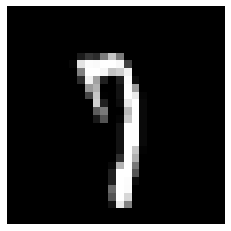

In [5]:
dataset = SqliteDB(X_train.shape, preprocess_fn=preprocess_fn)


plt.imshow(np.asarray(np.reshape(dataset[26354], (28, 28)) * 255, dtype=np.uint8), cmap='gray')
plt.axis('off')
plt.show()

The digit looks the same as above - everything seems to be working! Feel free to try out a few other images yourself.

## Train and predict with ivis
Time to train Ivis on the SQLite dataset.

Since training will be slower than on data stored in memory, we will train for just 5 epochs.

#### Unsupervised

In [6]:
# Set Ivis parameters
model = Ivis(build_index_on_disk=True, precompute=True, epochs=5)

# Train on SQLite dataset
model.fit(dataset)

Building KNN index


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:07<00:00, 220.74it/s]


Extracting KNN neighbours


100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [01:00<00:00, 987.02it/s]


Training neural network
Epoch 1/5
469/469 [==============================] - 42s 86ms/step - loss: 0.2143
Epoch 2/5
469/469 [==============================] - 40s 85ms/step - loss: 0.1350
Epoch 3/5
469/469 [==============================] - 40s 84ms/step - loss: 0.1193
Epoch 4/5
469/469 [==============================] - 39s 84ms/step - loss: 0.1135
Epoch 5/5
469/469 [==============================] - 40s 84ms/step - loss: 0.1103


Ivis(epochs=5)

On this machine the training takes around 45 seconds per epoch. For comparison, an epoch using data in memory takes 4 seconds.

469/469 [==============================] - 13s 28ms/step


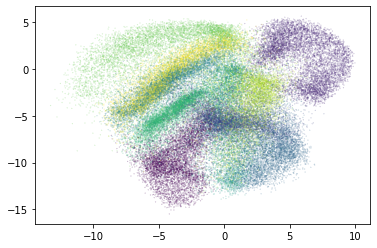

In [7]:
# Predict on the SQLite dataset
y_pred = model.transform(dataset)

# Plot the results
plt.figure()
plt.scatter(y_pred[:, 0], y_pred[:, 1], c=Y_train, s=0.01)

The different digits are grouped together with others with the same label as you would expect.

#### Supervised
You can also train the ivis model in supervised mode on the SQLite dataset - to keep things simple we'll use the labels stored in memory.

In [8]:
# Set Ivis parameters
model = Ivis(build_index_on_disk=True, precompute=True, epochs=5)

# Train in supervised mode on SQLite dataset and embed
y_pred = model.fit_transform(dataset, Y_train)

y_pred_proba = model.score_samples(dataset)
y_pred_classes = np.argmax(y_pred_proba, axis=1)

Building KNN index


100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:55<00:00, 269.45it/s]


Extracting KNN neighbours


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:59<00:00, 1008.40it/s]


Training neural network
Epoch 1/5
469/469 [==============================] - 43s 87ms/step - loss: 0.7843 - stacked_triplets_loss: 0.3050 - supervised_loss: 1.2636
Epoch 2/5
469/469 [==============================] - 40s 85ms/step - loss: 0.5500 - stacked_triplets_loss: 0.2615 - supervised_loss: 0.8385
Epoch 3/5
469/469 [==============================] - 39s 84ms/step - loss: 0.4727 - stacked_triplets_loss: 0.2528 - supervised_loss: 0.6925
Epoch 4/5
469/469 [==============================] - 40s 85ms/step - loss: 0.4168 - stacked_triplets_loss: 0.2420 - supervised_loss: 0.5917
Epoch 5/5
469/469 [==============================] - 13s 28ms/step


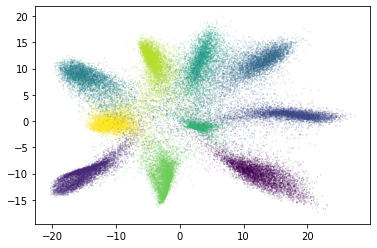

In [9]:
# Plot the supervised results

plt.figure()
plt.scatter(y_pred[:, 0], y_pred[:, 1], c=Y_train, s=0.01)

## Conclusion

Out-of memory datasets. Scaling ivis. Integrating into existing environments with SQL databases.

In [10]:
# Cleanup
import os
os.remove('mnist.sqlite')